# Clasificación de Fallos por medio del uso de redes neuronales y transferencia de conocimiento (Transfer learning)


## 1. Preparación del Entorno en Google Colab



In [18]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')


data_train='/content/drive/MyDrive/Maestria_IA/Modulo_10/proyecto2/data/train/'
data_valid='/content/drive/MyDrive/Maestria_IA/Modulo_10/proyecto2/data/valid'
data_test='/content/drive/MyDrive/Maestria_IA/Modulo_10/proyecto2/data/test'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Definir las dimensiones de las imágenes para MobileNetV2
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Cargar los datasets desde los directorios muestreados
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    labels='inferred',
    label_mode='int',  # Las etiquetas serán enteros (0, 1, 2, 3)
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 500 files belonging to 4 classes.


In [20]:
# el tratamiento es el mismo para Validación y test
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_valid, #dirección url
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_test,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 500 files belonging to 4 classes.
Found 500 files belonging to 4 classes.


In [21]:
# Guardar los nombres de las clases para referencia
class_names = train_dataset.class_names
print(f"Clases encontradas: {class_names}")

Clases encontradas: ['Critical Defect', 'Major Defect', 'Minor Defect', 'No defect']


In [22]:
# Función para preprocesar los datos
def preprocess(image, label):
   # Convertir el tensor de la imagen de uint8 a float32 antes de la normalización
    image = tf.cast(image, tf.float32)
    # La normalización es esencial para MobileNetV2
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Aplicar el preprocesamiento a los datasets
train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

PAsa 2 caraca de modelado

In [23]:
# Cargar el modelo MobileNetV2 pre-entrenado
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False, # sin capa final
    weights='imagenet'
)

# Congelar las capas del modelo base
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

# Construcción y compilación del modelo

In [24]:
from tensorflow.keras import layers, models
del(model)
# Definir la arquitectura del nuevo modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2), # Añadir una capa de Dropout con 20%
    layers.Dense(len(class_names), activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary() # Sumario completo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

paso 4 Entrenamiento

In [25]:
# Definir un callback para guardar los pesos del mejor modelo
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_can_classifier.h5',
    monitor='val_accuracy', #
    save_best_only=True,
    mode='max', #  monitorea 'val_accuracy', se usa 'max'
    verbose=1
)

# Definir un callback para detener el entrenamiento cuando no mejora
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitorear la pérdida de validación
    patience=5,         # Detener si no mejora en 3 épocas consecutivas
    restore_best_weights=True # Restaurar los pesos del mejor modelo encontrado
)


In [26]:

# Entrenar el modelo
epochs = 25
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2739 - loss: 1.5785
Epoch 1: val_accuracy improved from -inf to 0.51600, saving model to best_can_classifier.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 250s 15s/step - accuracy: 0.2783 - loss: 1.5700 - val_accuracy: 0.5160 - val_loss: 1.1514
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5694 - loss: 1.0795
Epoch 2: val_accuracy improved from 0.51600 to 0.56400, saving model to best_can_classifier.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5700 - loss: 1.0759 - val_accuracy: 0.5640 - val_loss: 0.9388
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6155 - loss: 0.8650
Epoch 3: val_accuracy improved from 0.56400 to 0.69800, saving model to best_can_classifier.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.6181 - loss: 0.8642 - val_accuracy: 0.6980 - val_loss: 0.7933
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6770 - loss: 0.7768
Epoch 4: val_accuracy improved from 0.69800 to 0.71600, saving model to best_can_classifier.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.6786 - loss: 0.7746 - val_accuracy: 0.7160 - val_loss: 0.7412
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7770 - loss: 0.6330
Epoch 5: val_accuracy improved from 0.71600 to 0.74000, saving model to best_can_classifier.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7751 - loss: 0.6347 - val_accuracy: 0.7400 - val_loss: 0.6830
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7774 - loss: 0.5765
Epoch 6: val_accuracy improved from 0.74000 to 0.75200, saving model to best_can_classifier.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7773 - loss: 0.5771 - val_accuracy: 0.7520 - val_loss: 0.6463
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7769 - loss: 0.5817
Epoch 7: val_accuracy improved from 0.75200 to 0.75600, saving model to best_can_classifier.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7775 - loss: 0.5797 - val_accuracy: 0.7560 - val_loss: 0.6186
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8330 - loss: 0.4830
Epoch 8: val_accuracy improved from 0.75600 to 0.79000, saving model to best_can_classifier.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8311 - loss: 0.4860 - val_accuracy: 0.7900 - val_loss: 0.5930
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8248 - loss: 0.4760
Epoch 9: val_accuracy did not improve from 0.79000
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8256 - loss: 0.4758 - val_accuracy: 0.7860 - val_loss: 0.5744
Epoch 10/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8337 - loss: 0.4540
Epoch 10: val_accuracy did not improve from 0.79000
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8340 - loss: 0.4537 - val_accuracy: 0.7640 - val_loss: 0.5798
Epoch 11/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8573 - loss: 0.4304
Epoch 11: val_accuracy did not improve from 0.79000
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8568 - loss: 0.4308 - val_accuracy: 0.7880 - val_loss: 0.5488
Epoch 12/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8638 - loss: 0.4015
Epoch 12: val_accuracy improved from 0.79000 to 0.

16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8627 - loss: 0.4027 - val_accuracy: 0.8120 - val_loss: 0.5299
Epoch 13/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8587 - loss: 0.3965
Epoch 13: val_accuracy did not improve from 0.81200
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8595 - loss: 0.3956 - val_accuracy: 0.8100 - val_loss: 0.5133
Epoch 14/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8998 - loss: 0.3326
Epoch 14: val_accuracy did not improve from 0.81200
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8987 - loss: 0.3346 - val_accuracy: 0.7920 - val_loss: 0.5166
Epoch 15/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8743 - loss: 0.3858
Epoch 15: val_accuracy did not improve from 0.81200
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8742 - loss: 0.3856 - val_accuracy: 0.7980 - val_loss: 0.5163
Epoch 16/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8813 - loss: 0.3368
Epoch 16: val_accuracy did not improve from 0.81

16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8776 - loss: 0.3401 - val_accuracy: 0.8300 - val_loss: 0.4819
Epoch 18/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9100 - loss: 0.3144
Epoch 18: val_accuracy did not improve from 0.83000
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9100 - loss: 0.3141 - val_accuracy: 0.8060 - val_loss: 0.4760
Epoch 19/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.8882 - loss: 0.3153
Epoch 19: val_accuracy did not improve from 0.83000
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8895 - loss: 0.3137 - val_accuracy: 0.8020 - val_loss: 0.4779
Epoch 20/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9013 - loss: 0.3238
Epoch 20: val_accuracy did not improve from 0.83000
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9018 - loss: 0.3228 - val_accuracy: 0.8220 - val_loss: 0.4616
Epoch 21/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9230 - loss: 0.2659
Epoch 21: val_accuracy did not improve from 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9210 - loss: 0.2544 - val_accuracy: 0.8320 - val_loss: 0.4380
Epoch 25/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9337 - loss: 0.2403
Epoch 25: val_accuracy did not improve from 0.83200
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9330 - loss: 0.2416 - val_accuracy: 0.8280 - val_loss: 0.4423


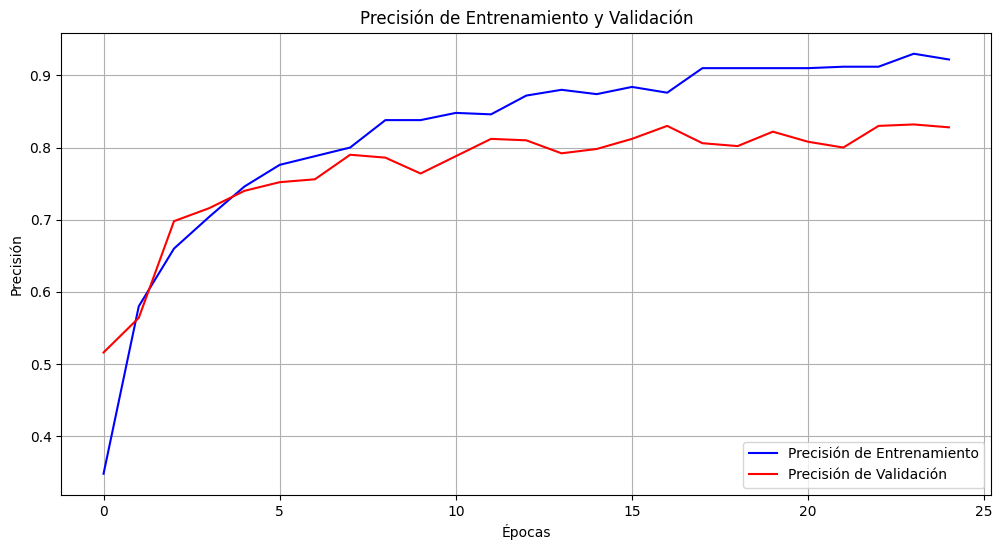

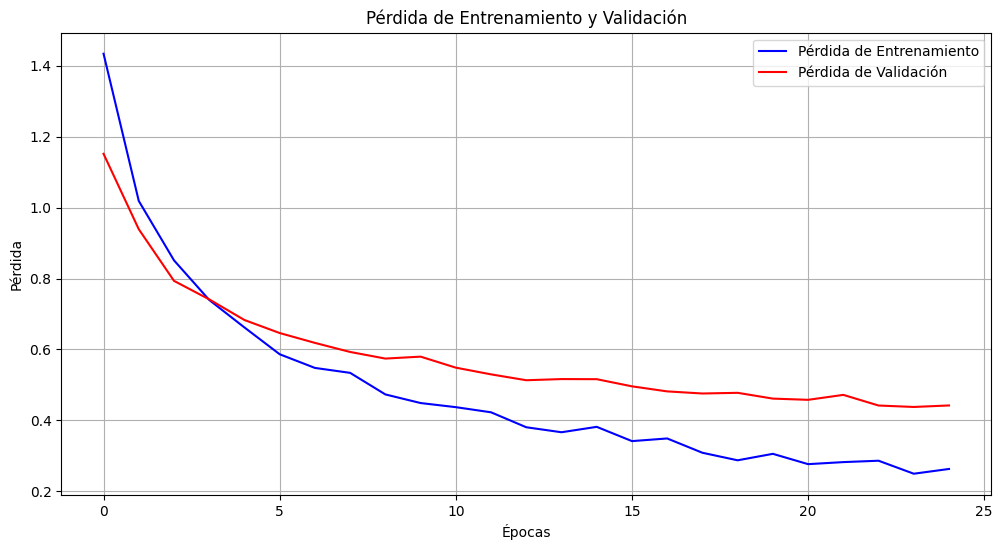

In [27]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Obtener los datos del historial de entrenamiento
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    # --- Graficar la Precisión (Accuracy) ---
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, acc, 'b', label='Precisión de Entrenamiento')
    plt.plot(epochs, val_acc, 'r', label='Precisión de Validación')
    plt.title('Precisión de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # --- Graficar la Pérdida (Loss) ---
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, 'b', label='Pérdida de Entrenamiento')
    plt.plot(epochs, val_loss, 'r', label='Pérdida de Validación')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

plot_training_history(history)

In [28]:

# Evaluar el modelo en el conjunto de prueba
print("\nEvaluando el modelo en el conjunto de prueba...")
model.load_weights('best_can_classifier.h5')
loss, accuracy = model.evaluate(test_dataset)

print(f"\nPrecisión en el conjunto de prueba: {accuracy:.4f}")
print(f"Pérdida en el conjunto de prueba: {loss:.4f}")




Evaluando el modelo en el conjunto de prueba...
16/16 ━━━━━━━━━━━━━━━━━━━━ 120s 7s/step - accuracy: 0.7857 - loss: 0.4851

Precisión en el conjunto de prueba: 0.8300
Pérdida en el conjunto de prueba: 0.4211



Modelo cargado exitosamente.

Evaluando 2 imágenes aleatorias por cada clase del conjunto de prueba:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


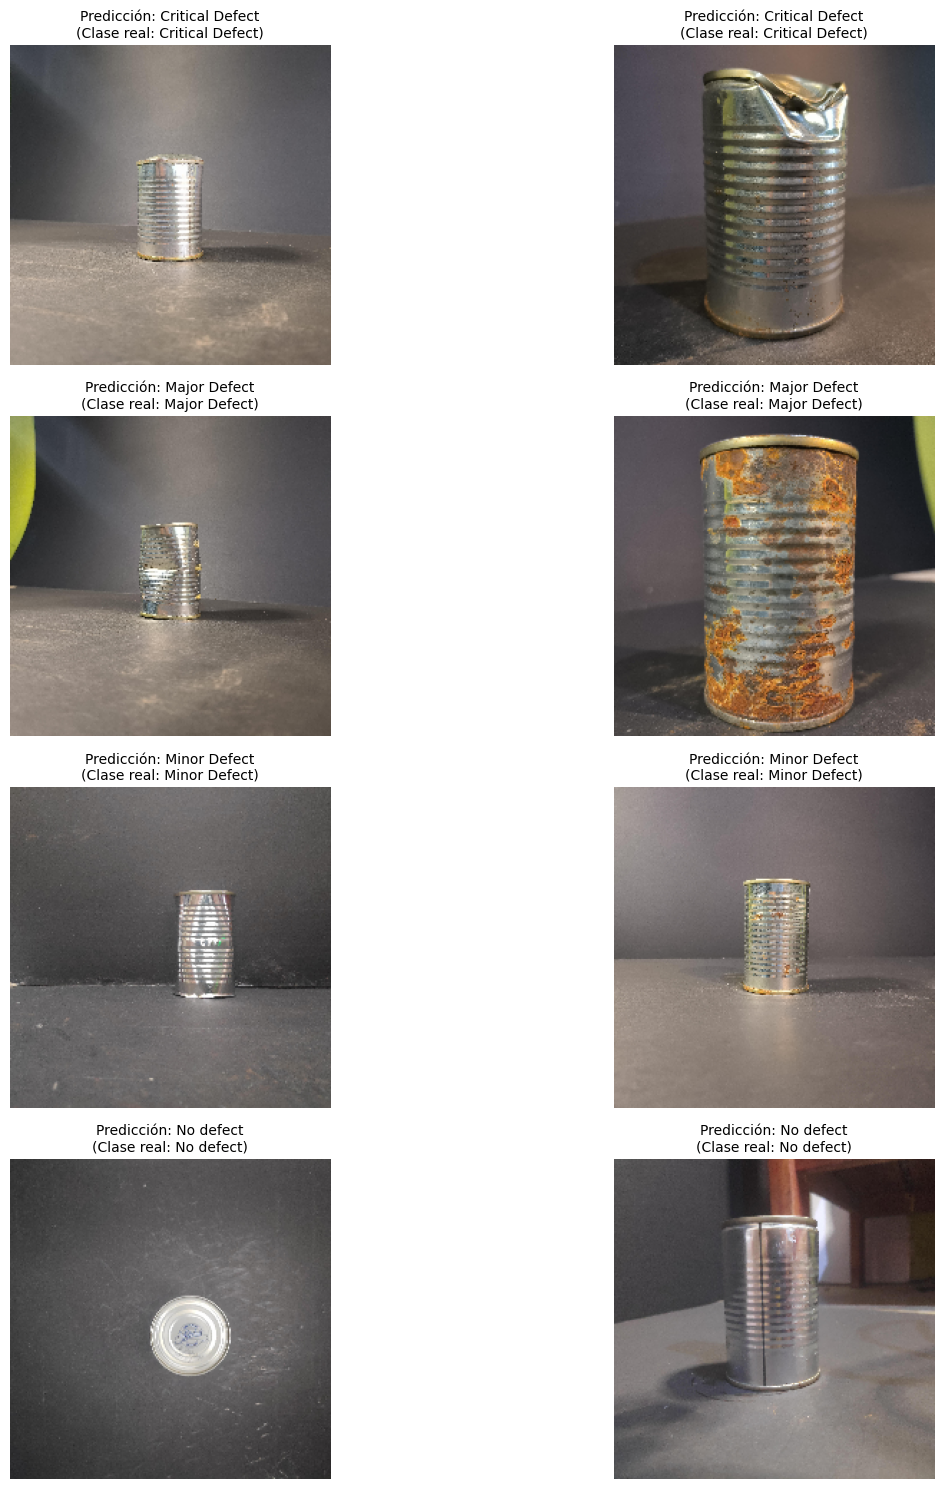

In [39]:
# --- Código para la evaluación del modelo con ejemplos aleatorios ---
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Definir la ruta del directorio de prueba y los nombres de las clases
data_test_path = '/content/drive/MyDrive/Maestria_IA/Modulo_10/proyecto2/data/train'
class_names = ['Critical Defect', 'Major Defect','Minor Defect', 'No defect']

# Cargar el modelo con los mejores pesos guardados
# Asegúrate de que el modelo se cargue con los mismos argumentos usados para la compilación
try:
    best_model = load_model('best_can_classifier.h5')
    print("\nModelo cargado exitosamente.")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")
    best_model = None

if best_model:
    print("\nEvaluando 2 imágenes aleatorias por cada clase del conjunto de prueba:")

    plt.figure(figsize=(15, 15)) # Crea una figura para los subplots

    plot_index = 1

    # Itera sobre cada clase
    for class_name in class_names:
        # Crea la ruta al directorio de la clase
        class_path = os.path.join(data_test_path, class_name)
        # Obtiene una lista de todas las imágenes en el directorio de la clase
        image_files = os.listdir(class_path)
        # Selecciona aleatoriamente 2 imágenes de la lista
        selected_images = random.sample(image_files, 2)

        # Itera sobre las dos imágenes seleccionadas
        for img_name in selected_images:
            img_path = os.path.join(class_path, img_name)

            # Carga la imagen y la redimensiona al tamaño requerido
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) # Añade una dimensión de batch
            img_array = preprocess_input(img_array) # Preprocesa la imagen para MobileNetV2

            # Realiza la predicción con el modelo
            predictions = best_model.predict(img_array)
            predicted_class_index = np.argmax(predictions[0])
            predicted_class_name = class_names[predicted_class_index]

            # Muestra la imagen y su predicción
            plt.subplot(4, 2, plot_index) # 4 filas, 2 columnas para 8 imágenes
            plt.imshow(img)
            plt.title(f"Predicción: {predicted_class_name}\n(Clase real: {class_name})", fontsize=10)
            plt.axis('off') # Desactiva los ejes

            plot_index += 1

    plt.tight_layout() # Ajusta los subplots para evitar solapamientos
    plt.show()